In [1]:
!gdown --id 1BZ0MUIu47u_J3Y4NDUU-5ZxVD1ZtvWzU

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BZ0MUIu47u_J3Y4NDUU-5ZxVD1ZtvWzU
From (redirected): https://drive.google.com/uc?id=1BZ0MUIu47u_J3Y4NDUU-5ZxVD1ZtvWzU&confirm=t&uuid=0ade6099-186e-41a2-82b2-3f1f80f7b82f
To: /content/Saved Split resized 500x500.zip
100% 291M/291M [00:06<00:00, 47.4MB/s]


In [2]:
!unzip '/content/Saved Split resized 500x500.zip' -d '/content/Saved Split resized 500x500'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_4_56_2280.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_0_43_217.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_2_37_1187.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_0_67_336.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_2_73_1367.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_2_62_1310.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_1_81_908.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_1_80_901.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_4_1_2006.JPG  
  inflating: /content/Saved Split resized 500x500/New 

In [3]:
!ls '/content/Saved Split resized 500x500'

'New folder'


In [4]:
base_dir = '/content/Saved Split resized 500x500/New folder' # Replace with the correct directory name

In [5]:
!pip install -q tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
train_dir = '/content/Saved Split resized 500x500/New folder/train'
val_dir = '/content/Saved Split resized 500x500/New folder/val'
test_dir = '/content/Saved Split resized 500x500/New folder/test'


In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE, class_mode='categorical')
valid_generator = val_test_datagen.flow_from_directory(val_dir, target_size=IMAGE_SIZE,
                                                       batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SIZE,
                                                      batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 9354 images belonging to 4 classes.
Found 1169 images belonging to 4 classes.
Found 1171 images belonging to 4 classes.


#VGG19

In [ ]:
# In cell 8
with tf.distribute.get_strategy().scope():
    input_shape = (224, 224, 3)
    # num_classes = 38 # The original value was 38 which was incorrect.
    num_classes = train_generator.num_classes # Get num_classes dynamically from generator

    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_VGG = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_VGG.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model_VGG.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,04

 Total params: 33,038,276 (126.03 MB)

 Trainable params: 13,012,100 (49.64 MB)

 Non-trainable params: 20,026,176 (76.39 MB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model_VGG.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=callbacks
)


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 161s 530ms/step - accuracy: 0.4094 - loss: 1.7682 - precision_3: 0.4360 - recall_3: 0.3579 - val_accuracy: 0.6416 - val_loss: 1.0326 - val_precision_3: 0.6974 - val_recall_3: 0.5894
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 187s 489ms/step - accuracy: 0.5559 - loss: 1.3155 - precision_3: 0.5897 - recall_3: 0.4981 - val_accuracy: 0.6861 - val_loss: 0.9071 - val_precision_3: 0.7184 - val_recall_3: 0.6373
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 139s 473ms/step - accuracy: 0.5843 - loss: 1.1626 - precision_3: 0.6239 - recall_3: 0.5361 - val_accuracy: 0.6826 - val_loss: 0.9688 - val_precision_3: 0.7121 - val_recall_3: 0.6621
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 141s 481ms/step - accuracy: 0.6229 - loss: 1.0534 - precision_3: 0.6597 - recall_3: 0.5743 - val_accuracy: 0.7237 - val_loss: 0.7786 - val_precision_3: 0.7644 - val_recall_3: 0.6826
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 142s 486ms/step - accuracy: 0.6498 - loss: 0.9777 - precision_3: 0.6899 

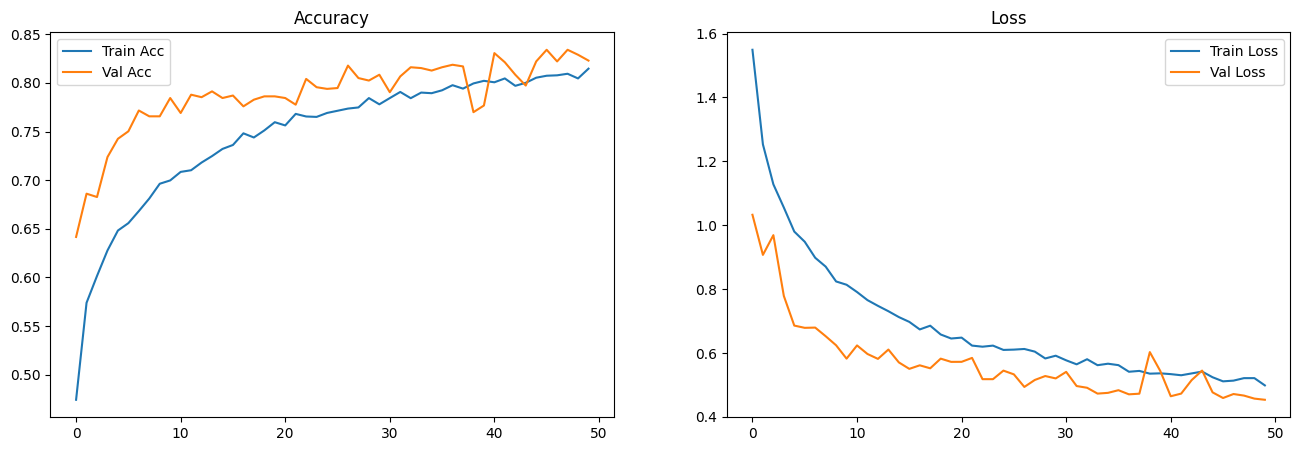

In [ ]:
def draw_plots(history):
    plt.figure(figsize=(16, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

draw_plots(history)


In [ ]:
predictions = model_VGG.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step
Classification Report:

              precision    recall  f1-score   support

       Algal       0.85      0.90      0.88       299
       Fresh       0.89      0.78      0.83       280
      Insect       0.92      0.81      0.86       298
      powder       0.77      0.90      0.83       294

    accuracy                           0.85      1171
   macro avg       0.86      0.85      0.85      1171
weighted avg       0.86      0.85      0.85      1171



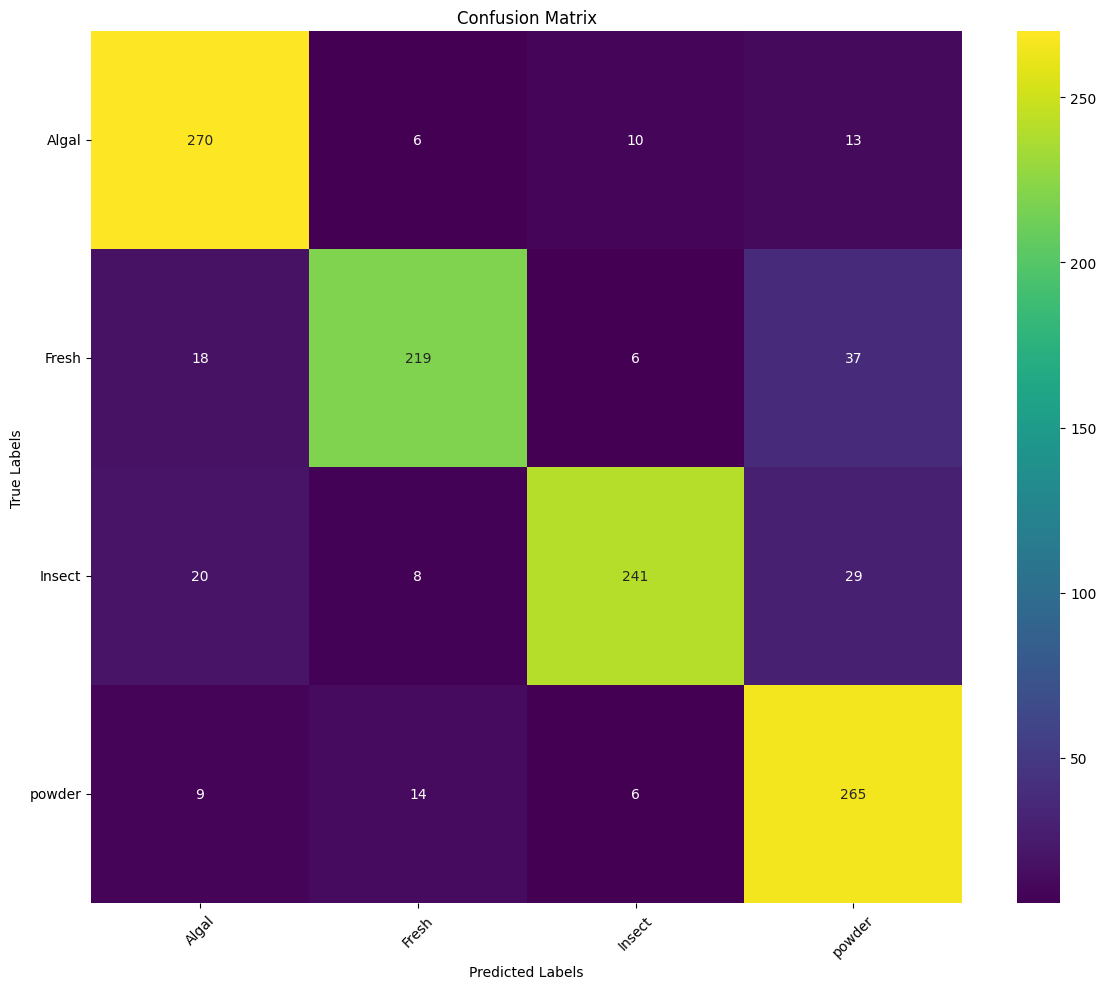

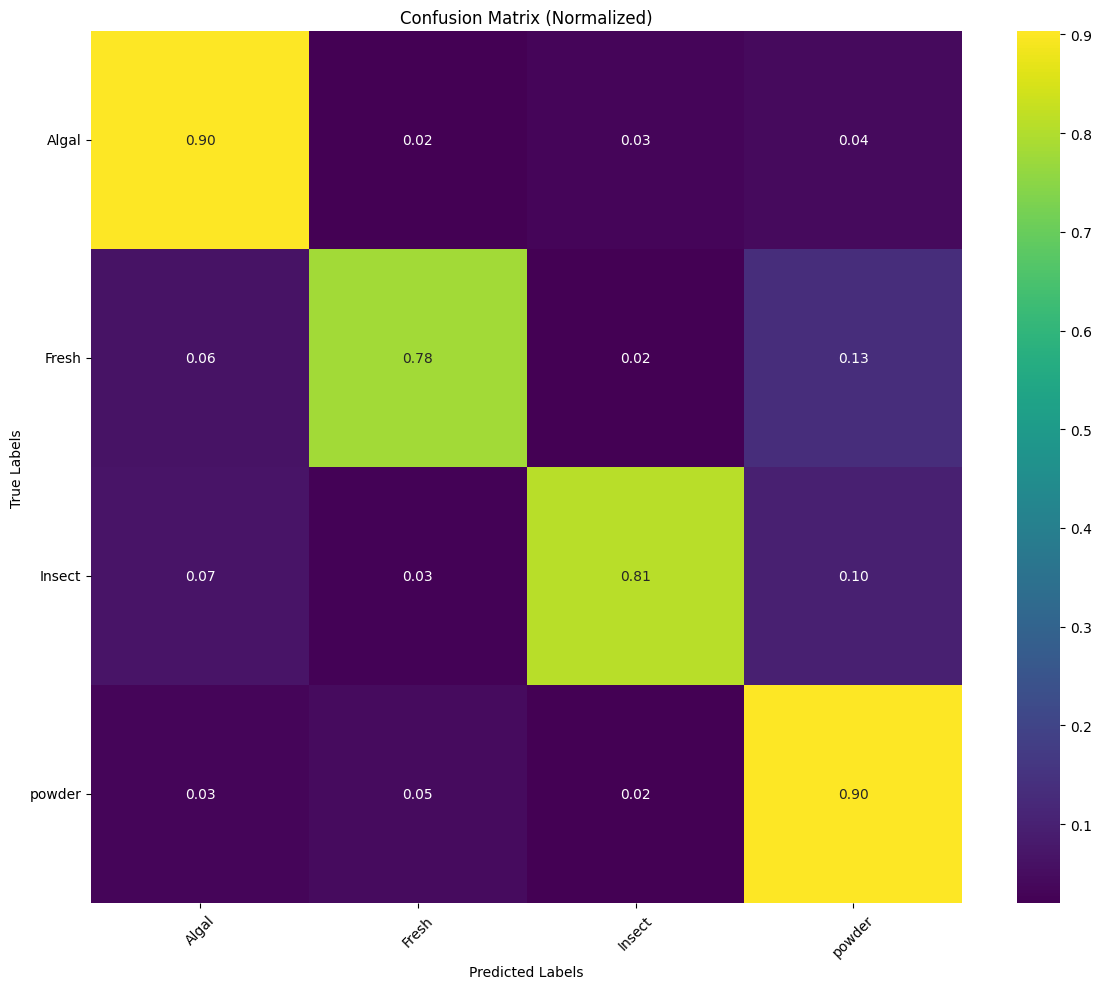

In [ ]:
def draw_confusion_matrix(true, preds, class_names, normalize=None):
    cm = confusion_matrix(true, preds, normalize=normalize)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Usage
draw_confusion_matrix(y_true, y_pred, class_names=class_names)
draw_confusion_matrix(y_true, y_pred, class_names=class_names, normalize='true')


In [ ]:
model_VGG.save("/content/VGG19_PlantDisease_run2.h5")
model_loaded = tf.keras.models.load_model("/content/VGG19_PlantDisease_run2.h5")


In [ ]:
columns = [
    'Loss Train', 'Loss Valid', 'Loss Test',
    'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
    'Precision Train', 'Precision Valid', 'Precision Test',
    'Recall Train', 'Recall Valid', 'Recall Test'
]


In [ ]:
import pandas as pd

# Evaluate on train, val, and test sets
train_metrics = model_VGG.evaluate(train_generator, verbose=0)
val_metrics = model_VGG.evaluate(valid_generator, verbose=0)
test_metrics = model_VGG.evaluate(test_generator, verbose=0)

# Extract metrics
report_vgg = pd.DataFrame([[
    train_metrics[0], val_metrics[0], test_metrics[0],   # Losses
    train_metrics[1], val_metrics[1], test_metrics[1],   # Accuracies
    train_metrics[2], val_metrics[2], test_metrics[2],   # Precisions
    train_metrics[3], val_metrics[3], test_metrics[3]    # Recalls
]], columns=[
    'Loss Train', 'Loss Valid', 'Loss Test',
    'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
    'Precision Train', 'Precision Valid', 'Precision Test',
    'Recall Train', 'Recall Valid', 'Recall Test'
])

report_vgg


Loss Train  Loss Valid  Loss Test  Accuracy Train  Accuracy Valid  \
0    0.392853    0.453459   0.418099        0.858136        0.822926   

   Accuracy Test  Precision Train  Precision Valid  Precision Test  \
0       0.849701         0.884585         0.853236        0.872187   

   Recall Train  Recall Valid  Recall Test  
0       0.82756      0.800684     0.827498

In [ ]:
# In cell 8
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC

# MCC function
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


In [ ]:
# In cell 8
with tf.distribute.get_strategy().scope():
    input_shape = (224, 224, 3)
    num_classes = train_generator.num_classes  # Get num_classes dynamically from generator

    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_VGG = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_VGG.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            AUC(name='AUC'),
            matthews_correlation
        ]
    )


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model_VGG.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 186s 569ms/step - AUC: 0.6786 - accuracy: 0.4214 - loss: 1.7135 - matthews_correlation: 0.2283 - precision: 0.4464 - recall: 0.3618 - val_AUC: 0.8740 - val_accuracy: 0.6707 - val_loss: 0.9066 - val_matthews_correlation: 0.5532 - val_precision: 0.7026 - val_recall: 0.6185
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 142s 486ms/step - AUC: 0.7964 - accuracy: 0.5598 - loss: 1.2877 - matthews_correlation: 0.4166 - precision: 0.5931 - recall: 0.5132 - val_AUC: 0.8938 - val_accuracy: 0.7203 - val_loss: 0.8340 - val_matthews_correlation: 0.6345 - val_precision: 0.7593 - val_recall: 0.6826
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 139s 474ms/step - AUC: 0.8241 - accuracy: 0.5933 - loss: 1.1620 - matthews_correlation: 0.4549 - precision: 0.6238 - recall: 0.5440 - val_AUC: 0.9061 - val_accuracy: 0.7365 - val_loss: 0.7958 - val_matthews_correlation: 0.6472 - val_precision: 0.7597 - val_recall: 0.7032
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 140s 479ms/step - AUC: 0

RUN for CUrve

In [8]:
# In cell 8
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC

# MCC function
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


In [9]:
# In cell 8
with tf.distribute.get_strategy().scope():
    input_shape = (224, 224, 3)
    num_classes = train_generator.num_classes  # Get num_classes dynamically from generator

    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_VGG = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_VGG.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            AUC(name='AUC'),
            matthews_correlation
        ]
    )


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model_VGG.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 207s 580ms/step - AUC: 0.6726 - accuracy: 0.4076 - loss: 1.7543 - matthews_correlation: 0.2195 - precision: 0.4362 - recall: 0.3607 - val_AUC: 0.8760 - val_accuracy: 0.6724 - val_loss: 0.8953 - val_matthews_correlation: 0.5795 - val_precision: 0.7299 - val_recall: 0.6219
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 149s 509ms/step - AUC: 0.7876 - accuracy: 0.5471 - loss: 1.3466 - matthews_correlation: 0.4034 - precision: 0.5829 - recall: 0.5042 - val_AUC: 0.8961 - val_accuracy: 0.7092 - val_loss: 0.8514 - val_matthews_correlation: 0.6212 - val_precision: 0.7398 - val_recall: 0.6835
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 147s 502ms/step - AUC: 0.8222 - accuracy: 0.5863 - loss: 1.1869 - matthews_correlation: 0.4504 - precision: 0.6177 - recall: 0.5422 - val_AUC: 0.8928 - val_accuracy: 0.7151 - val_loss: 0.8315 - val_matthews_correlation: 0.6137 - val_precision: 0.7462 - val_recall: 0.6638
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 148s 504ms/step - AUC: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step


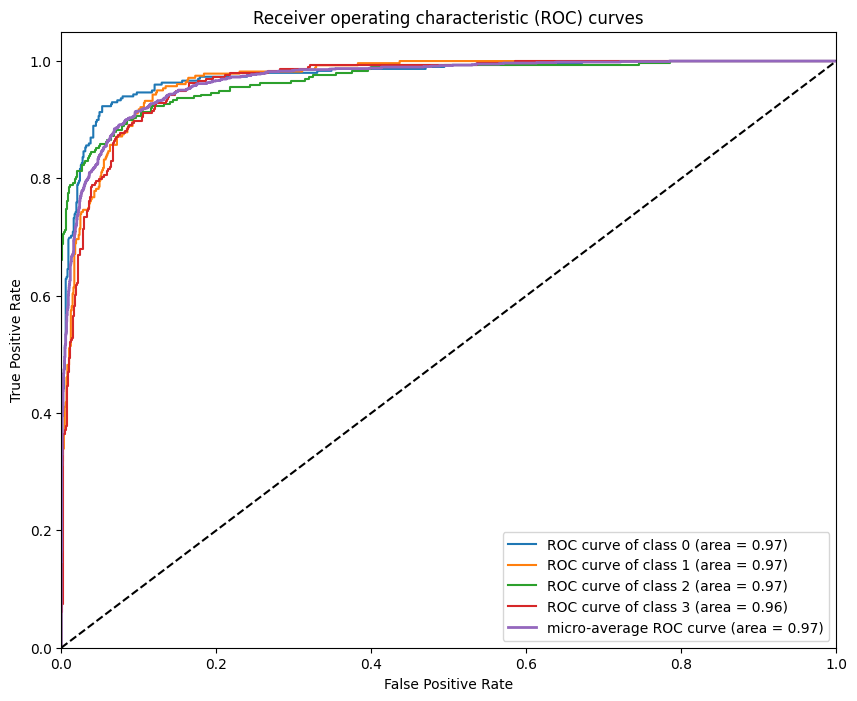

In [13]:
# prompt: create ROC curve for the dataset

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get predictions and true labels from the test generator
predictions = model_VGG.predict(test_generator)
y_true = test_generator.classes  # Assign y_true here

# Binarize the output labels
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# ... (Rest of your code remains the same) ...

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC curve (area = {roc_auc['micro']:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curves')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd

In [14]:
# prompt: create classification report with MCC for every class

from sklearn.metrics import matthews_corrcoef

# ... (Your existing code) ...

predictions = model_VGG.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("Classification Report with MCC for each class:\n")

# Calculate and print classification report with MCC
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
for class_name in class_names:
    mcc = matthews_corrcoef(y_true == np.where(np.array(class_names) == class_name)[0][0], y_pred == np.where(np.array(class_names) == class_name)[0][0])
    print(f"Class: {class_name}")
    print(f"  Precision: {report[class_name]['precision']:.4f}")
    print(f"  Recall: {report[class_name]['recall']:.4f}")
    print(f"  F1-score: {report[class_name]['f1-score']:.4f}")
    print(f"  Support: {report[class_name]['support']}")
    print(f"  MCC: {mcc:.4f}\n")

print(f"Overall Accuracy: {report['accuracy']:.4f}")


# ... (Rest of your code) ...


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step
Classification Report with MCC for each class:

Class: Algal
  Precision: 0.8742
  Recall: 0.8829
  F1-score: 0.8785
  Support: 299.0
  MCC: 0.8366

Class: Fresh
  Precision: 0.8583
  Recall: 0.7786
  F1-score: 0.8165
  Support: 280.0
  MCC: 0.7640

Class: Insect
  Precision: 0.8328
  Recall: 0.8523
  F1-score: 0.8425
  Support: 298.0
  MCC: 0.7879

Class: powder
  Precision: 0.8032
  Recall: 0.8469
  F1-score: 0.8245
  Support: 294.0
  MCC: 0.7641

Overall Accuracy: 0.8412


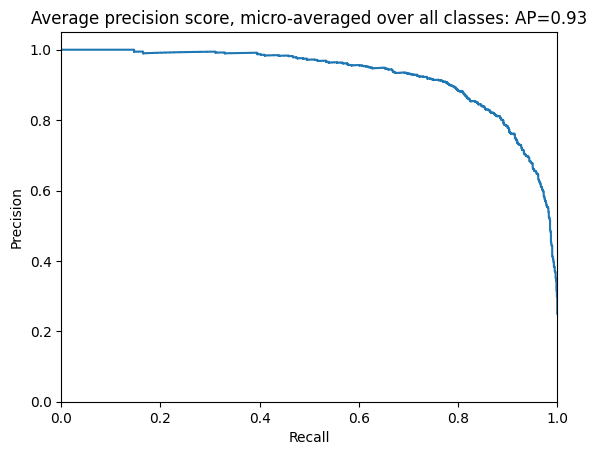

In [15]:
# prompt: Create PR curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(), predictions.ravel()
)
average_precision["micro"] = average_precision_score(y_true_bin, predictions, average="micro")


plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"])
)
plt.show()


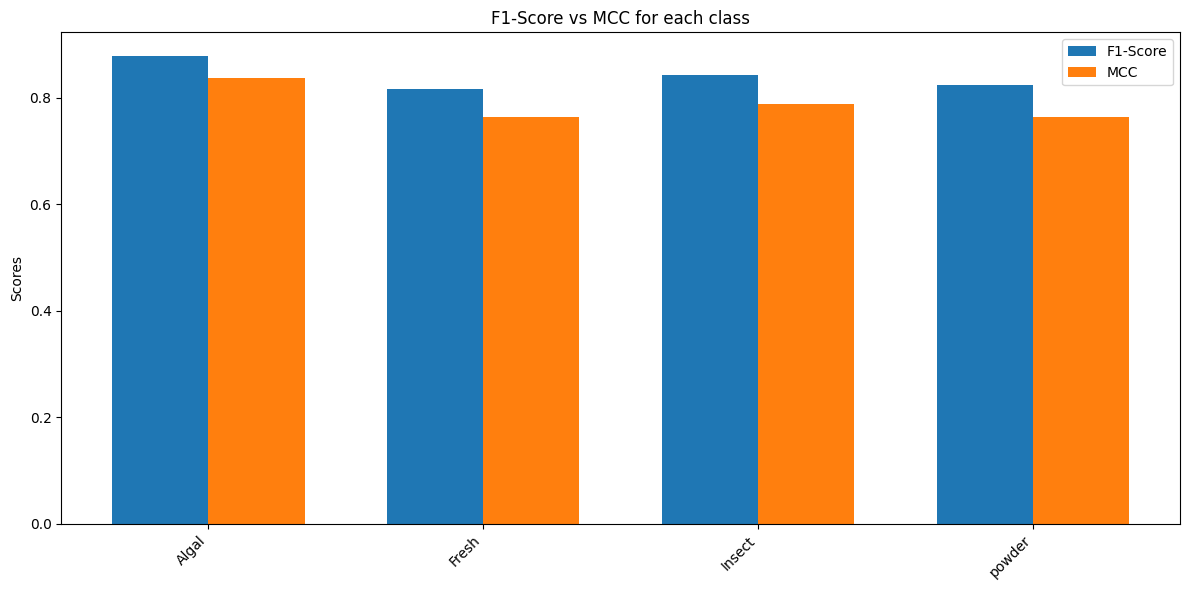

In [16]:
# prompt: Create F1 score vs MCC bar chart for all classes

import matplotlib.pyplot as plt

# Assuming 'report' dictionary from the classification report is available
# and contains the precision, recall, f1-score, and support for each class.
# Also, you need to calculate MCC for each class (as shown in your code).


f1_scores = []
mcc_scores = []
class_names = list(test_generator.class_indices.keys())

for class_name in class_names:
    f1_scores.append(report[class_name]['f1-score'])
    mcc = matthews_corrcoef(y_true == np.where(np.array(class_names) == class_name)[0][0], y_pred == np.where(np.array(class_names) == class_name)[0][0])
    mcc_scores.append(mcc)

x = range(len(class_names))  # Positions on the x-axis

width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, f1_scores, width, label='F1-Score')
rects2 = ax.bar([i + width for i in x], mcc_scores, width, label='MCC')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1-Score vs MCC for each class')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(class_names, rotation=45, ha="right")  # Rotate x-axis labels
ax.legend()

plt.tight_layout()
plt.show()


end

In [ ]:
import pandas as pd

# Evaluate on train, val, and test sets
train_metrics = model_VGG.evaluate(train_generator, verbose=0)
val_metrics = model_VGG.evaluate(valid_generator, verbose=0)
test_metrics = model_VGG.evaluate(test_generator, verbose=0)

# Metric order: [loss, accuracy, precision, recall, AUC, MCC]
report_vgg = pd.DataFrame([[

    train_metrics[0], val_metrics[0], test_metrics[0],   # Losses
    train_metrics[1], val_metrics[1], test_metrics[1],   # Accuracies
    train_metrics[2], val_metrics[2], test_metrics[2],   # Precisions
    train_metrics[3], val_metrics[3], test_metrics[3],   # Recalls
    train_metrics[4], val_metrics[4], test_metrics[4],   # AUCs
    train_metrics[5], val_metrics[5], test_metrics[5]    # MCCs

]], columns=[
    'Loss Train', 'Loss Valid', 'Loss Test',
    'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
    'Precision Train', 'Precision Valid', 'Precision Test',
    'Recall Train', 'Recall Valid', 'Recall Test',
    'AUC Train', 'AUC Valid', 'AUC Test',
    'MCC Train', 'MCC Valid', 'MCC Test'
])

report_vgg


Loss Train  Loss Valid  Loss Test  Accuracy Train  Accuracy Valid  \
0    0.432061    0.435566   0.406119        0.842634        0.828058   

   Accuracy Test  Precision Train  Precision Valid  Precision Test  \
0       0.850555         0.867129         0.852995        0.870852   

   Recall Train  Recall Valid  Recall Test  AUC Train  AUC Valid  AUC Test  \
0      0.815587      0.804106     0.829206   0.967433   0.967003  0.970971   

   MCC Train  MCC Valid  MCC Test  
0   0.790126   0.774503   0.79965

In [ ]:
# prompt: Using dataframe report_vgg: make it a table

# Convert the DataFrame to a table format
report_vgg.to_markdown()


'|    |   Loss Train |   Loss Valid |   Loss Test |   Accuracy Train |   Accuracy Valid |   Accuracy Test |   Precision Train |   Precision Valid |   Precision Test |   Recall Train |   Recall Valid |   Recall Test |   AUC Train |   AUC Valid |   AUC Test |   MCC Train |   MCC Valid |   MCC Test |\n|---:|-------------:|-------------:|------------:|-----------------:|-----------------:|----------------:|------------------:|------------------:|-----------------:|---------------:|---------------:|--------------:|------------:|------------:|-----------:|------------:|------------:|-----------:|\n|  0 |     0.432061 |     0.435566 |    0.406119 |         0.842634 |         0.828058 |        0.850555 |          0.867129 |          0.852995 |         0.870852 |       0.815587 |       0.804106 |      0.829206 |    0.967433 |    0.967003 |   0.970971 |    0.790126 |    0.774503 |    0.79965 |'

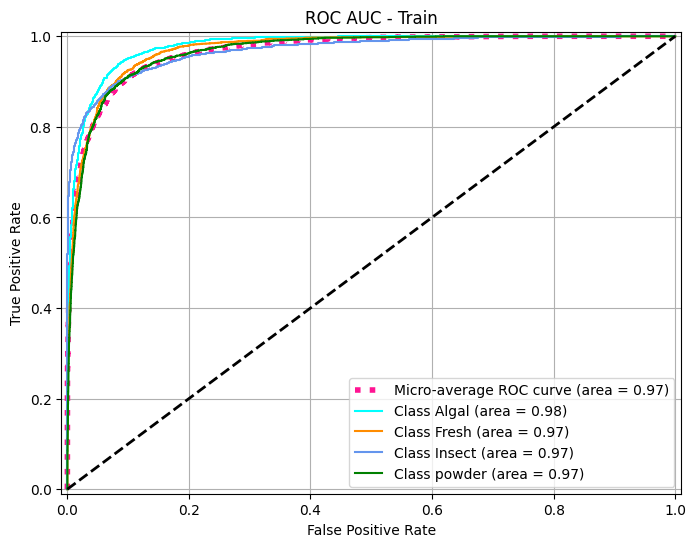

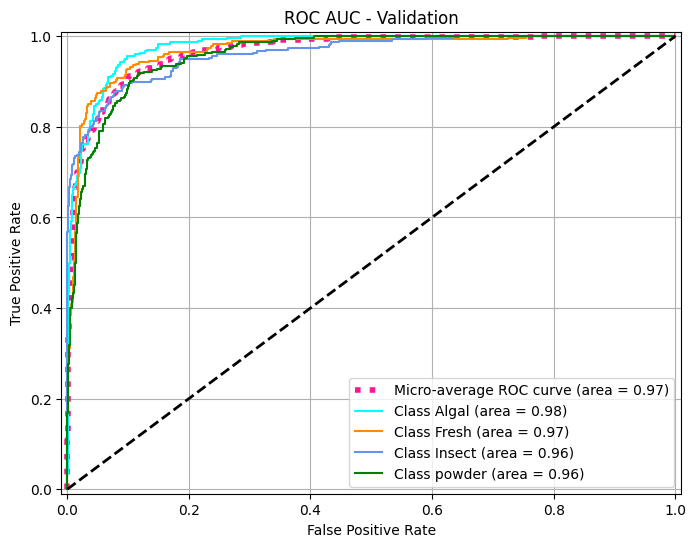

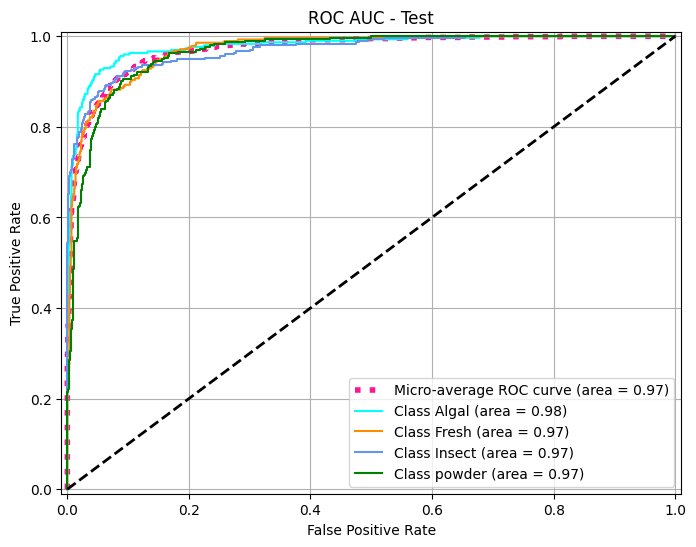

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import itertools

# Get class count
num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())

# Helper: Get true labels and predictions
def get_labels_and_preds(generator):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x, y = generator[i]
        y_true.append(y)
        y_pred.append(model_VGG.predict(x, verbose=0))
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

# Helper: Plot ROC AUC
def plot_roc_auc(y_true, y_pred, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC - {title}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot for each dataset
for gen, name in zip([train_generator, valid_generator, test_generator], ['Train', 'Validation', 'Test']):
    y_true, y_pred = get_labels_and_preds(gen)
    plot_roc_auc(y_true, y_pred, title=name)


In [ ]:
# prompt: save the model and download it

from google.colab import files
files.download("/content/VGG19_PlantDisease_run2.h5")


In [ ]:
!pip install rembg onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
from rembg import remove


In [ ]:
!pip install rembg # Install the rembg library

import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io
#from rembg import remove # Import the remove function from rembg

# ... (Rest of your code remains the same) ...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'onnxruntime'

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io
from rembg import remove

# Load the model
model_loaded = tf.keras.models.load_model("/content/VGG19_PlantDisease_final.h5")

# Dummy class names — replace this with actual test_generator.class_indices if available
class_names = ['Algal', 'Fresh', 'Insect', 'Powder']  # Replace with real class names

# Function to preprocess the image
def preprocess_image(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Function to predict the class
def predict_image(image):
    image = preprocess_image(image)
    prediction = model_loaded.predict(image)
    predicted_class = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class]
    return predicted_class_name

# Upload image button
uploaded = files.upload()

for filename in uploaded.keys():
    image_bytes = uploaded[filename]
    try:
        # Open image and convert to RGB
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Remove background
        image_nobg = remove(image)

        # Convert to PIL Image if not already
        if not isinstance(image_nobg, Image.Image):
            image_nobg = Image.fromarray(image_nobg)

        # Make prediction
        prediction = predict_image(image_nobg)
        print(f"The predicted class for {filename} is: {prediction}")

        # Display the image
        plt.imshow(image_nobg)
        plt.title(f"Prediction: {prediction}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing {filename}: {e}")


Saving 11.jpg to 11 (1).jpg
Error processing 11 (1).jpg: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 224, 224, 4)


In [ ]:
# prompt: write confusion matrix code

# Assuming y_true and y_pred are already defined from your model's predictions on the test set
# and class_names is a list of class labels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(true, preds, class_names, normalize=None):
    cm = confusion_matrix(true, preds, normalize=normalize)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Usage
draw_confusion_matrix(y_true, y_pred, class_names=class_names)
draw_confusion_matrix(y_true, y_pred, class_names=class_names, normalize='true')


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step
Classification report : 
               precision    recall  f1-score   support

       Algal       0.89      0.89      0.89       299
       Fresh       0.77      0.89      0.83       280
      Insect       0.91      0.82      0.86       298
      powder       0.84      0.82      0.83       294

    accuracy                           0.85      1171
   macro avg       0.85      0.85      0.85      1171
weighted avg       0.85      0.85      0.85      1171

Confusion matrix : 



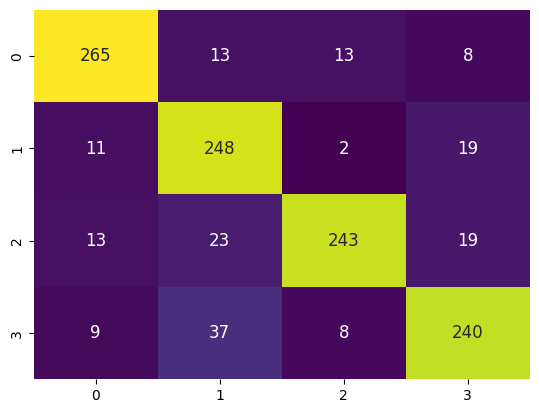

Normalized confusion matrix : 



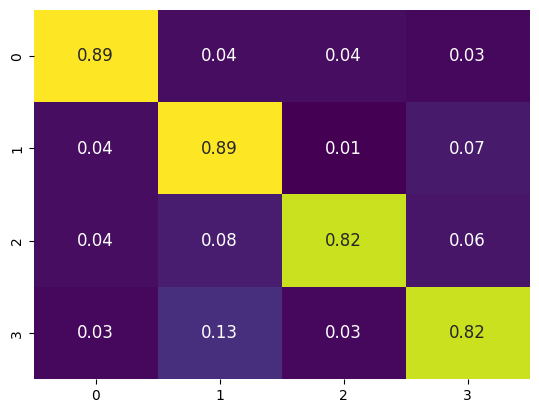

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_VGG.predict(test_generator)

y_pred = predictions.argmax(axis=-1)

class_names = list(test_generator.class_indices.keys())

print("Classification report : \n",classification_report(test_generator.labels, y_pred, target_names = class_names))

def draw_confusion_matrix(true, preds, normalize=None):
    conf_matx = confusion_matrix(true, preds, normalize = normalize)
    conf_matx = np.round(conf_matx, 2)

    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
    plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, "true")

F1 Score and MCC Comparison (Bar Chart)

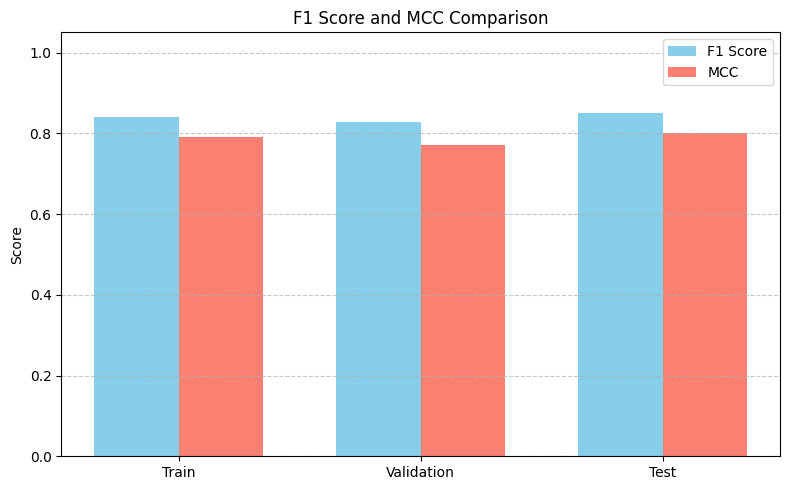

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, matthews_corrcoef

# Helper: Get predictions and true labels from a generator
def get_preds_and_labels(generator):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x, y = generator[i]
        preds = model_VGG.predict(x, verbose=0)
        y_true.append(y)
        y_pred.append(preds)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

# Helper: Compute F1 and MCC
def compute_metrics(y_true, y_pred):
    y_true_cls = np.argmax(y_true, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true_cls, y_pred_cls, average='macro')
    mcc = matthews_corrcoef(y_true_cls, y_pred_cls)
    return f1, mcc

# Compute for each set
f1_mcc_results = []
for gen in [train_generator, valid_generator, test_generator]:
    y_true, y_pred = get_preds_and_labels(gen)
    f1, mcc = compute_metrics(y_true, y_pred)
    f1_mcc_results.append((f1, mcc))

# Prepare bar chart
labels = ['Train', 'Validation', 'Test']
f1_scores = [item[0] for item in f1_mcc_results]
mcc_scores = [item[1] for item in f1_mcc_results]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
plt.bar(x + width/2, mcc_scores, width, label='MCC', color='salmon')

plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.title('F1 Score and MCC Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


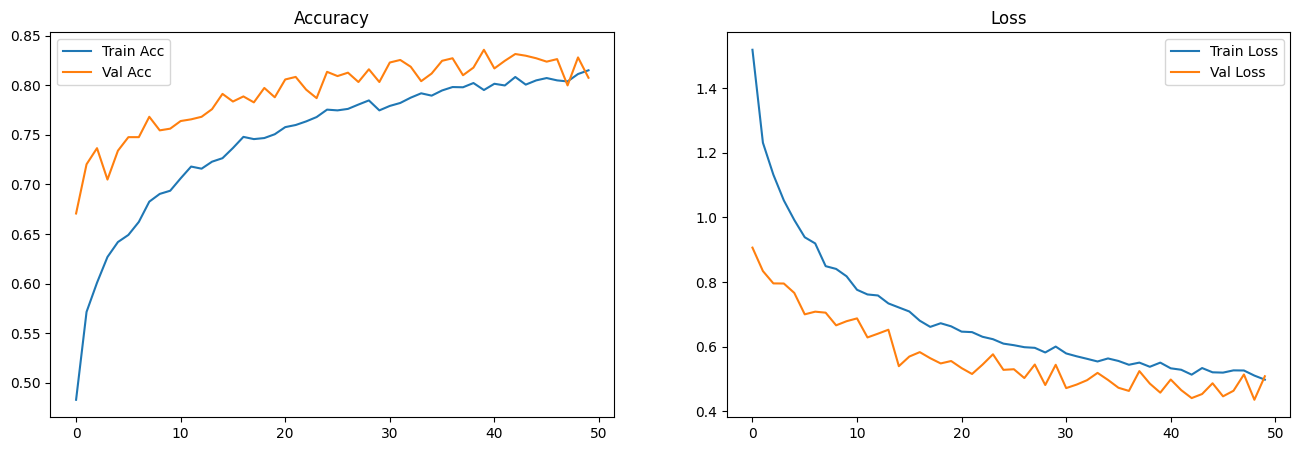

In [ ]:
# Cell 18:
def draw_plots(history):
    plt.figure(figsize=(16, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    # Access accuracy using 'accuracy' key, or 'acc' if 'accuracy' is not present
    plt.plot(history.history.get('accuracy', history.history.get('acc', [])), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

draw_plots(history) # Pass the history variable to the draw_plots function

Accuracy Trend (Line Chart)

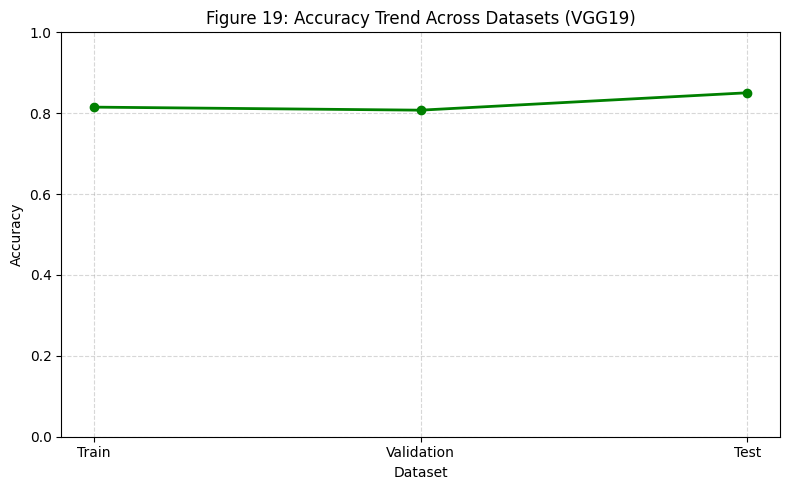

In [ ]:
import matplotlib.pyplot as plt

# Assuming you want to plot accuracy for 'Train', 'Validation', 'Test' datasets
datasets = ['Train', 'Validation', 'Test']  # Define the datasets list

# Extract accuracies from the history object
accuracies = [history.history['accuracy'][-1],  # Last training accuracy
              history.history['val_accuracy'][-1],  # Last validation accuracy
              model_VGG.evaluate(test_generator, verbose=0)[1]]  # Test accuracy

plt.figure(figsize=(8, 5))
plt.plot(datasets, accuracies, marker='o', linestyle='-', color='green', linewidth=2)
plt.title('Figure 19: Accuracy Trend Across Datasets (VGG19)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# prompt: save the model and make it download

from google.colab import files
files.download("/content/VGG19_PlantDisease_run2.h5")


FileNotFoundError: Cannot find file: /content/VGG19_PlantDisease_run2.h5

#DenseNet201

In [ ]:
input_shape = (224, 224, 3)

with tf.distribute.get_strategy().scope():
    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_tensor=inputs)

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(38, activation='softmax')(x)

    model_DenseNet = tf.keras.models.Model(inputs = inputs, outputs = outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_DenseNet.compile(optimizer= optimizer, loss="categorical_crossentropy", metrics=["accuracy",'precision','recall'])

model_DenseNet.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 66,664,166 (254.30 MB)

 Trainable params: 48,340,390 (184.40 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

# Define model_checkpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

In [ ]:
input_shape = (224, 224, 3)

with tf.distribute.get_strategy().scope():
    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_tensor=inputs)

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Get the number of classes from the train_generator
    num_classes = train_generator.num_classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Change this line

    model_DenseNet = tf.keras.models.Model(inputs = inputs, outputs = outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_DenseNet.compile(optimizer= optimizer, loss="categorical_crossentropy", metrics=["accuracy",'precision','recall'])

model_DenseNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 66,659,780 (254.29 MB)

 Trainable params: 48,336,004 (184.39 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
history = model_DenseNet.fit(train_generator,
                           epochs = 50,
                           batch_size=32,
                           validation_data = valid_generator,
                           callbacks = callbacks
                           )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 262s 708ms/step - accuracy: 0.5877 - loss: 1.0926 - precision: 0.6375 - recall: 0.5250 - val_accuracy: 0.7314 - val_loss: 0.6975 - val_precision: 0.7560 - val_recall: 0.7023 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 162s 475ms/step - accuracy: 0.7444 - loss: 0.6872 - precision: 0.7824 - recall: 0.7000 - val_accuracy: 0.7887 - val_loss: 0.5512 - val_precision: 0.8132 - val_recall: 0.7562 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 144s 490ms/step - accuracy: 0.7866 - loss: 0.5736 - precision: 0.8166 - recall: 0.7451 - val_accuracy: 0.8272 - val_loss: 0.4580 - val_precision: 0.8537 - val_recall: 0.7990 - learning_rate: 0.0010
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 128s 435ms/step - accuracy: 0.7995 - loss: 0.5296 - precision: 0.8330 - recall: 0.7664 - val_accuracy: 0.8255 - val_loss: 0.4585 - val_precision: 0.8504 - val_recall: 0.7973 - learning_rate: 0.0010
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 153s 522

In [ ]:
def Evaluate_model(model, train_generator, valid_generator, test_generator):
    """
    Evaluates a model on the train, validation, and test sets.

    Args:
        model: The Keras model to evaluate.
        train_generator: The data generator for the training set.
        valid_generator: The data generator for the validation set.
        test_generator: The data generator for the test set.

    Returns:
        A list containing the evaluation metrics for the train, validation,
        and test sets, respectively.
    """
    train_metrics = model.evaluate(train_generator, verbose=0)
    val_metrics = model.evaluate(valid_generator, verbose=0)
    test_metrics = model.evaluate(test_generator, verbose=0)

    return [
        train_metrics[0], val_metrics[0], test_metrics[0],  # Losses
        train_metrics[1], val_metrics[1], test_metrics[1],  # Accuracies
        train_metrics[2], val_metrics[2], test_metrics[2],  # Precisions
        train_metrics[3], val_metrics[3], test_metrics[3]   # Recalls
    ]

Report_DenseNet = []
Report_DenseNet.append(Evaluate_model(model_DenseNet, train_generator, valid_generator, test_generator))
Report_DenseNet

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[[0.17141473293304443,
  0.23088912665843964,
  0.1962110549211502,
  0.940453290939331,
  0.9118905067443848,
  0.9385141134262085,
  0.9438880085945129,
  0.9163071513175964,
  0.9406196475028992,
  0.9369253516197205,
  0.9084687829017639,
  0.9333902597427368]]

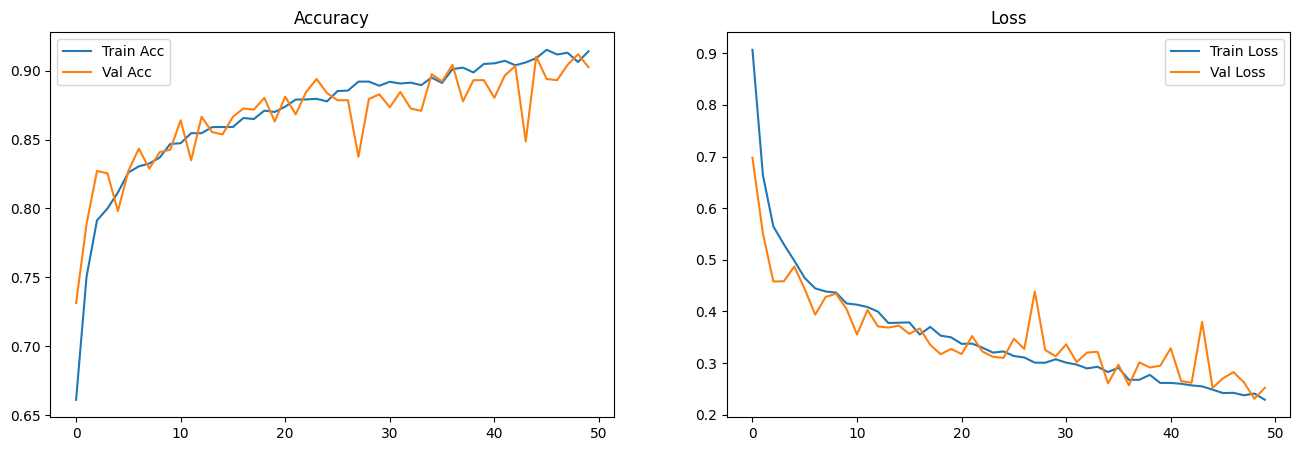

In [ ]:
# Cell 18:
def draw_plots(history):
    plt.figure(figsize=(16, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    # Access accuracy using 'accuracy' key, or 'acc' if 'accuracy' is not present
    plt.plot(history.history.get('accuracy', history.history.get('acc', [])), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

draw_plots(history) # Pass the history variable to the draw_plots function

37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 681ms/step
Classification report : 
               precision    recall  f1-score   support

       Algal       0.95      0.97      0.96       299
       Fresh       0.93      0.94      0.94       280
      Insect       0.98      0.88      0.93       298
      powder       0.90      0.96      0.93       294

    accuracy                           0.94      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.94      0.94      0.94      1171

Confusion matrix : 



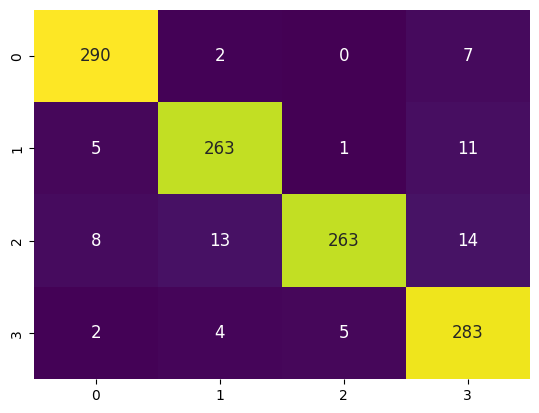

Normalized confusion matrix : 



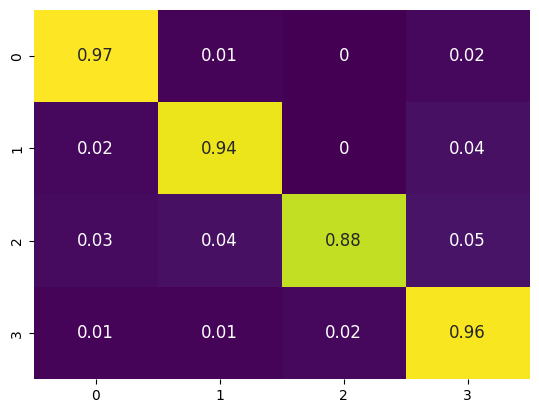

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_DenseNet.predict(test_generator)

y_pred = predictions.argmax(axis=-1)

class_names = list(test_generator.class_indices.keys())

print("Classification report : \n",classification_report(test_generator.labels, y_pred, target_names = class_names))

def draw_confusion_matrix(true, preds, normalize=None):
    conf_matx = confusion_matrix(true, preds, normalize = normalize)
    conf_matx = np.round(conf_matx, 2)

    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
    plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, "true")

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step
Classification report : 
               precision    recall  f1-score   support

       Algal       0.95      0.97      0.96       299
       Fresh       0.93      0.94      0.94       280
      Insect       0.98      0.88      0.93       298
      powder       0.90      0.96      0.93       294

    accuracy                           0.94      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.94      0.94      0.94      1171

Confusion matrix : 



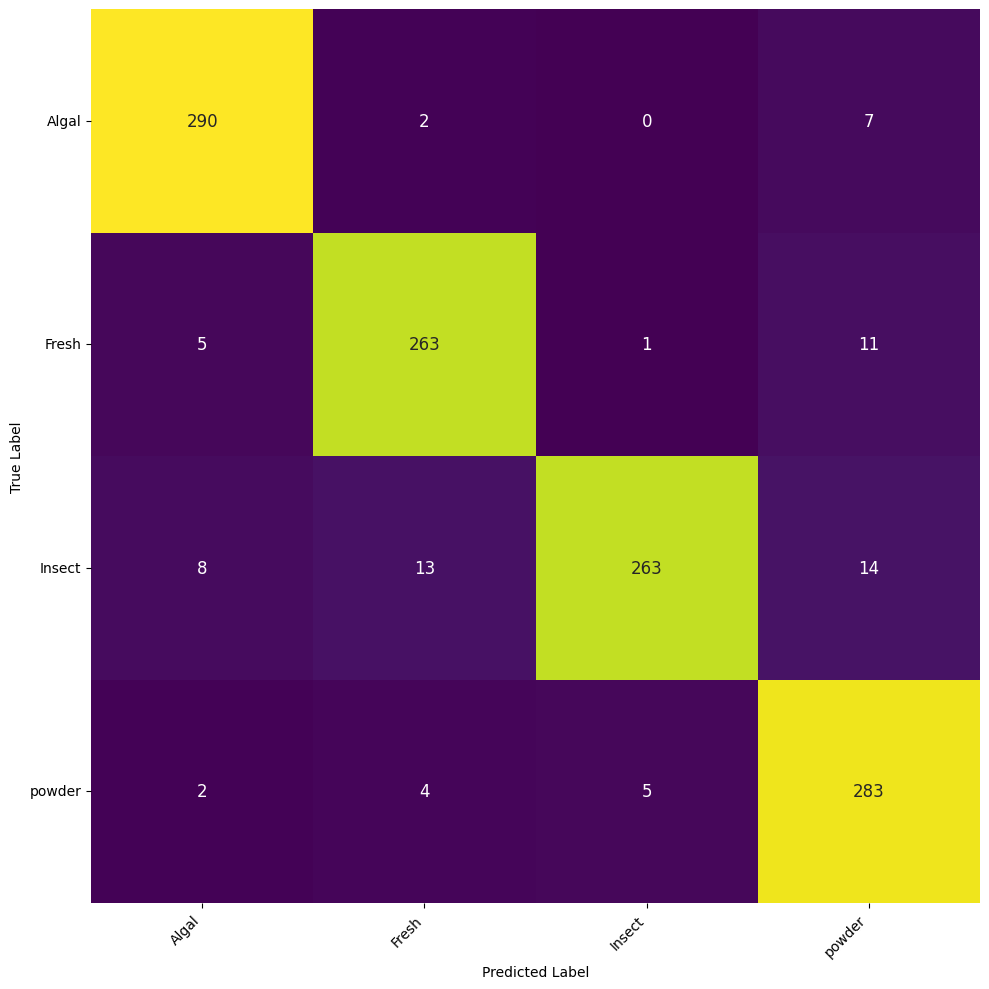

Normalized confusion matrix : 



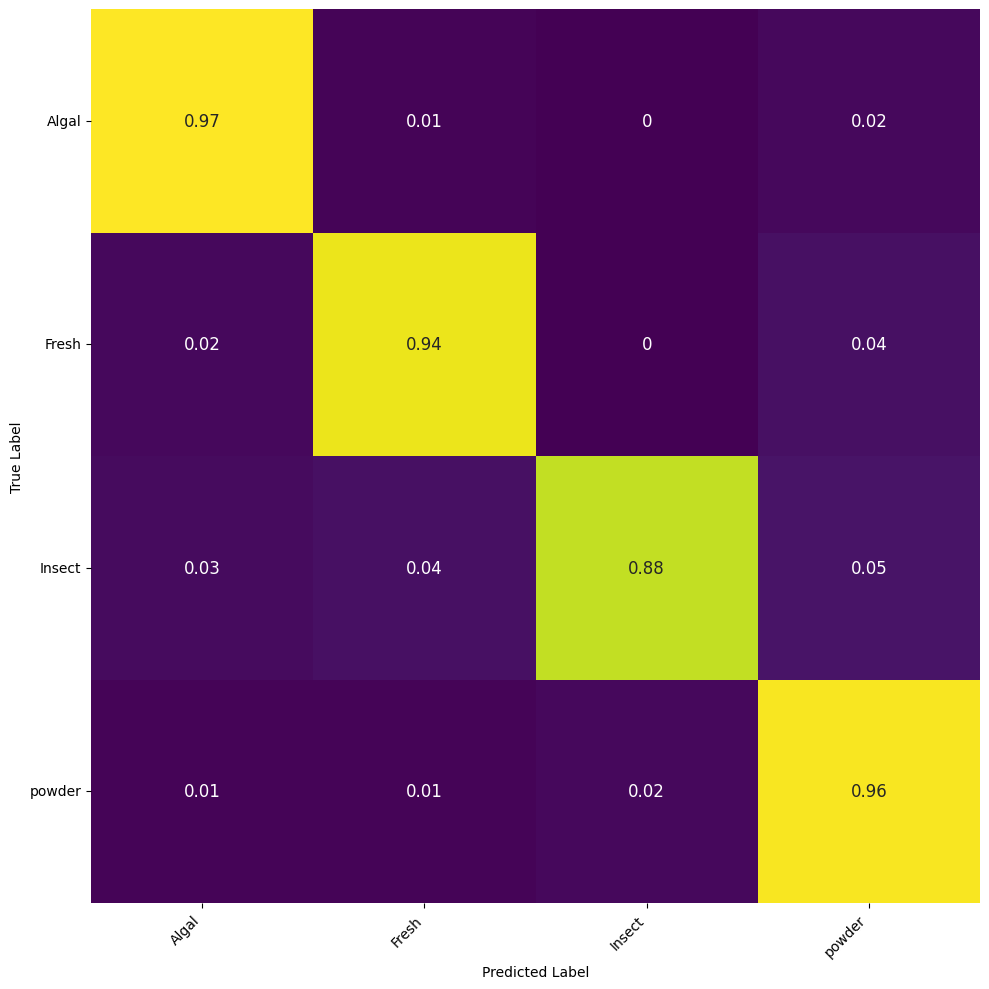

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions = model_DenseNet.predict(test_generator)
y_pred = predictions.argmax(axis=-1)
class_names = list(test_generator.class_indices.keys())

print("Classification report : \n", classification_report(test_generator.labels, y_pred, target_names=class_names))

def draw_confusion_matrix(true, preds, class_names, normalize=None):
    conf_matx = confusion_matrix(true, preds, normalize=normalize)
    conf_matx = np.round(conf_matx, 2)

    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figsize if needed
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12}, fmt="g", cbar=False, cmap="viridis",
                xticklabels=class_names, yticklabels=class_names, ax=ax)  # Add labels
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, class_names)  # Pass class_names

print("Normalized confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, class_names, normalize="true")  # Pass class_names

In [ ]:
import pandas as pd # Import the pandas library with the alias

In [ ]:
# Define column names
columns = ['Loss Train', 'Loss Valid', 'Loss Test',
           'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
           'Precision Train', 'Precision Valid', 'Precision Test',
           'Recall Train', 'Recall Valid', 'Recall Test']

# Convert Report_DenseNet to DataFrame
df_densenet = pd.DataFrame(Report_DenseNet, columns=columns)

# Display the DataFrame
print("Performance Metrics Table for DenseNet201 Model")
display(df_densenet)


Performance Metrics Table for DenseNet201 Model


Loss Train  Loss Valid  Loss Test  Accuracy Train  Accuracy Valid  \
0    0.171415    0.230889   0.196211        0.940453        0.911891   

   Accuracy Test  Precision Train  Precision Valid  Precision Test  \
0       0.938514         0.943888         0.916307         0.94062   

   Recall Train  Recall Valid  Recall Test  
0      0.936925      0.908469      0.93339

In [ ]:
# Define test directory
test_dir = os.path.join(base_dir, "test") # Assuming 'test' is your test data folder

# Create test dataset
test_dataset_vgg = datasets.ImageFolder(root=test_dir, transform=val_transform_vgg)

# Create test data loader
test_loader_vgg = DataLoader(test_dataset_vgg, batch_size=32, shuffle=False, num_workers=2)

NameError: name 'datasets' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


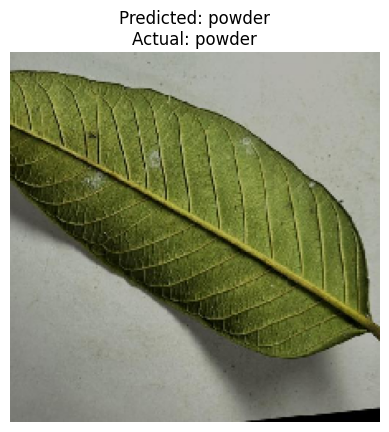

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


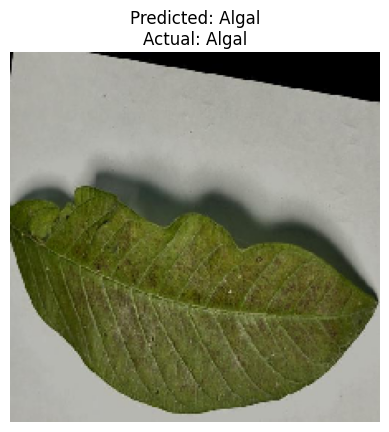

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


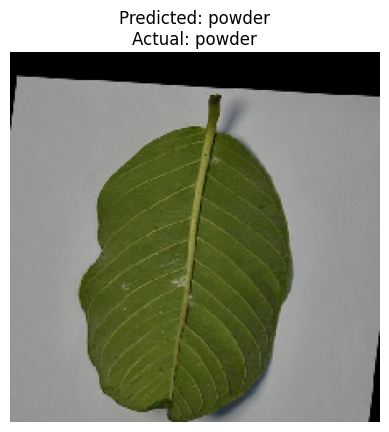

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


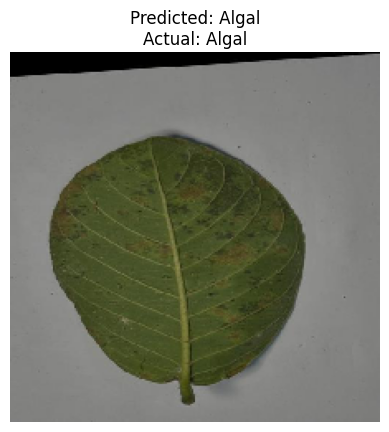

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


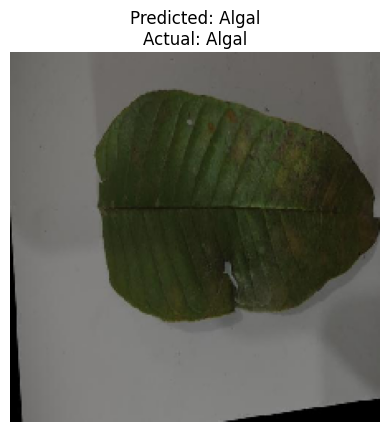

In [ ]:
# prompt: make the densenet model do prediction on test data by selecting them randomly and showing predicted label and actual label. show the images and predicted laben and actual label

import random
import matplotlib.pyplot as plt

# Assuming test_generator and class_names are defined from the previous code

# Get a random set of indices from the test set
num_samples_to_display = 5  # Adjust the number of samples to display
random_indices = random.sample(range(len(test_generator.filenames)), num_samples_to_display)

for i in random_indices:
    # Predict the label for the image at the current index
    image, label = test_generator[i // BATCH_SIZE][0][i % BATCH_SIZE], test_generator[i // BATCH_SIZE][1][i % BATCH_SIZE]
    prediction = model_DenseNet.predict(np.expand_dims(image, axis=0))
    predicted_label_index = np.argmax(prediction)
    predicted_label = class_names[predicted_label_index]
    actual_label = class_names[np.argmax(label)]

    # Display the image, predicted, and actual labels
    plt.figure()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_718']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


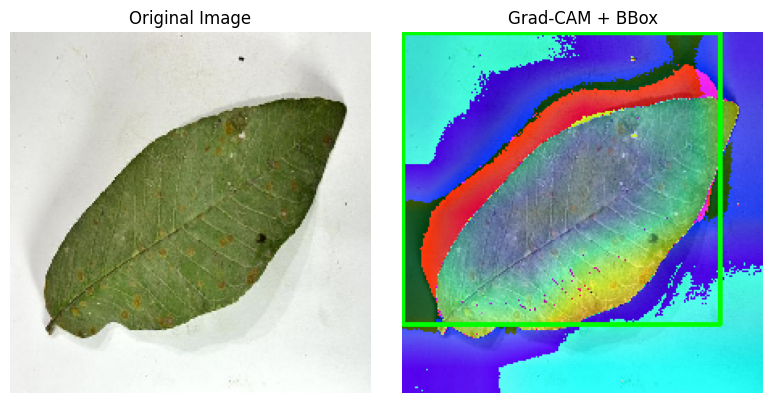

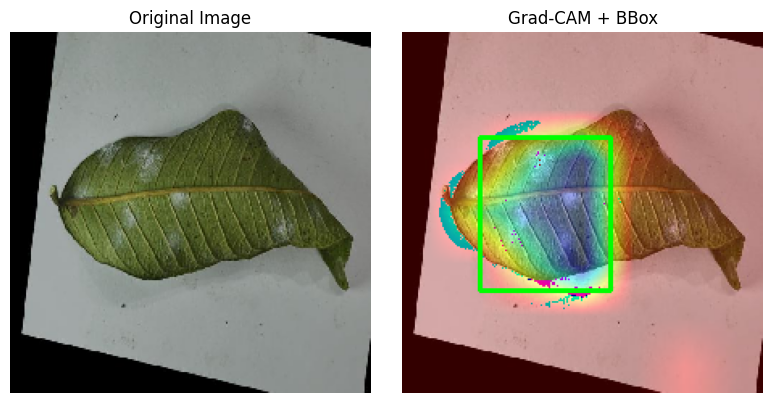

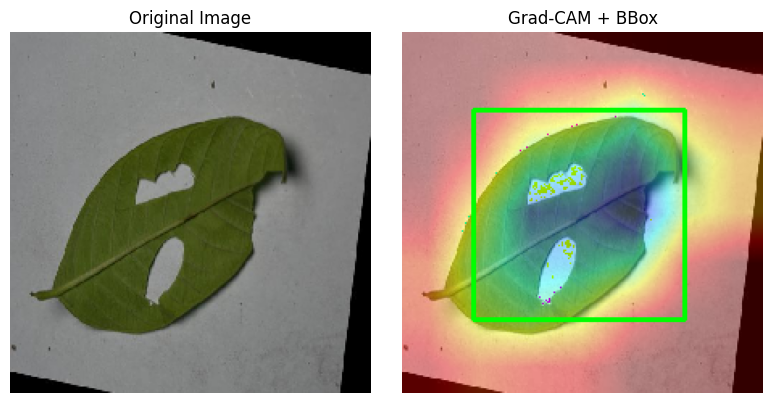

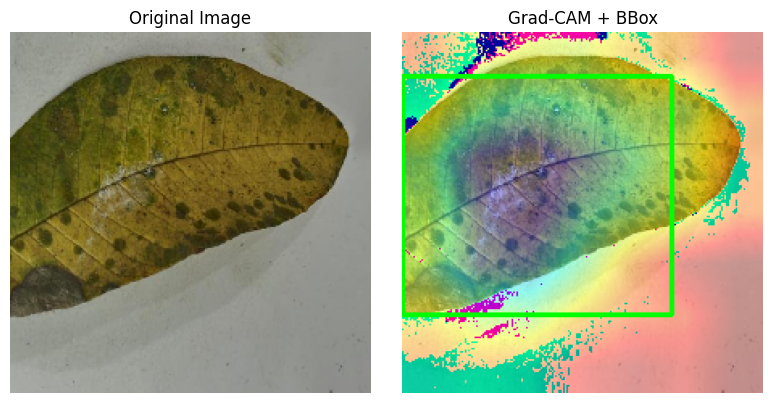

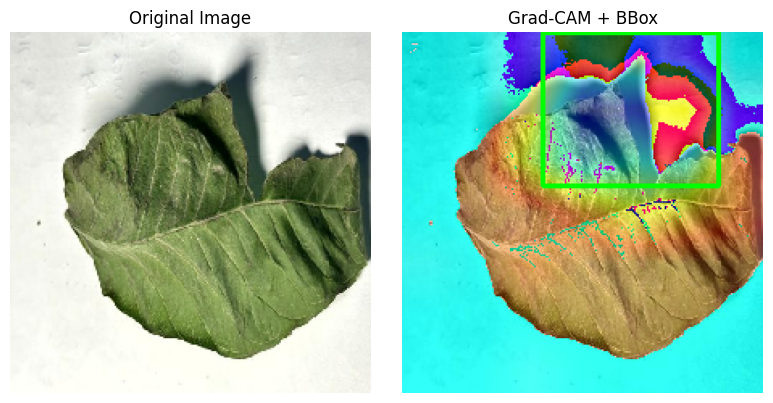

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam_with_bboxes(original_img, heatmap, threshold=0.5, alpha=0.4):
    # Resize and normalize heatmap
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_normalized = np.uint8(255 * heatmap_resized)

    # Apply color map
    heatmap_color = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = heatmap_color * alpha + original_img
    superimposed_img = np.uint8(superimposed_img)

    # Threshold and find contours
    _, binary_map = cv2.threshold(heatmap_normalized, int(threshold * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    boxed_img = superimposed_img.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return boxed_img

# Visualize Grad-CAM with bounding boxes on random test samples
num_samples = 5
random_indices = random.sample(range(len(test_generator.filenames)), num_samples)

for i in random_indices:
    img_path = test_generator.filepaths[i]
    original_pil = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_pil)
    img_array = np.expand_dims(original_img, axis=0) / 255.0

    heatmap = make_gradcam_heatmap(img_array, model_DenseNet, last_conv_layer_name="conv5_block32_concat")
    gradcam_boxed = display_gradcam_with_bboxes(np.uint8(original_img), heatmap)

    # Show results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_pil)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gradcam_boxed)
    plt.title("Grad-CAM + BBox")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
